# Домашнее задание  
## по теме «Полиноминальная регрессия» 

 Столбец “Premium Amount” является целевой переменной

Импорт библиотек

In [3]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import statsmodels.api as sm
from eda_tools import get_all_outliers, get_boxplot, get_eda, get_cat_eda, get_correlation_target # Тут мои функции что бы кода меньше было в блокноте


In [ ]:
archive_path = 'input_data/train.zip'
# Открываем архив
with zipfile.ZipFile(archive_path, 'r') as archive:
 
    with archive.open('train.csv') as file:
        df = pd.read_csv(file)

### Подготовка исходных данных

In [11]:
df.info(memory_usage=True) # Вывод столбцов и их типов
df.head() # Вывод "шапки"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
# Переименование столбцов
df.columns = df.columns.str.lower().str.replace(' ', '_')

### Числовые переменные

In [5]:
eda_df = get_eda(df)
eda_df

,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
age,18705,1.558750e-02,64.000000,18.000000,41.145563,41.000000,1.833302e+02,22.000000,60.000000,30.000000,53.000000,0,float64,47,0,0,0
annual_income,44949,3.745750e-02,149997.000000,1.000000,32745.217777,23911.000000,1.035521e+09,2627.000000,81075.000000,8001.000000,44634.000000,0,float64,88593,0,0,67132
number_of_dependents,109672,9.139333e-02,4.000000,0.000000,2.009934,2.000000,2.008846e+00,0.000000,4.000000,1.000000,3.000000,0,float64,5,218124,0,0
health_score,74076,6.173000e-02,58.975914,2.012237,25.613908,24.578648,1.489245e+02,9.936849,43.281339,15.918959,34.527209,1125924,float64,532657,0,0,0
previous_claims,364029,3.033575e-01,9.000000,0.000000,1.002689,1.000000,9.659748e-01,0.000000,2.000000,0.000000,2.000000,0,float64,10,305433,0,369
vehicle_age,6,5.000000e-06,19.000000,0.000000,9.569889,10.000000,3.336436e+01,2.000000,18.000000,5.000000,15.000000,0,float64,20,61615,0,0
credit_score,137882,1.149017e-01,849.000000,300.000000,592.924350,595.000000,2.249458e+04,383.000000,792.000000,468.000000,721.000000,0,float64,550,0,0,0
insurance_duration,1,8.333333e-07,9.000000,1.000000,5.018219,5.000000,6.730555e+00,1.000000,9.000000,3.000000,7.000000,0,float64,9,0,0,0
premium_amount,0,0.000000e+00,4999.000000,20.000000,1102.544822,872.000000,7.482230e+05,150.000000,2363.000000,514.000000,1509.000000,0,float64,4794,0,0,49320


In [6]:
# Обработка пропусков числовых полей

# age 1,5% пропусков
df = df.dropna(subset=['age']) # удаляю пропуски

# annual_income 
df = df.dropna(subset=['annual_income']) # удаляю пропуски

# number_of_dependents есть предположение что это техническая ошибка и там должен быть 0
df['number_of_dependents'] = df['number_of_dependents'].fillna(0) # пропуски заполняю 0

# health_score

df = df.dropna(subset=['health_score']) # удаляю пропуски

# previous_claims. Учитывая малое количесвто 0, часто обращаются по страховым случаям.
df['previous_claims'] = df['previous_claims'].fillna(df['previous_claims'].median()) # заменю пропуски на медиану

# vehicle_age
df = df.dropna(subset=['vehicle_age']) # удаляю пропуски

# credit_score
df['credit_score'] = df['credit_score'].fillna(df['credit_score'].median()) # заменю пропуски на медиану

# insurance_duration
df = df.dropna(subset=['insurance_duration']) # удаляю пропуски

Категориальные переменные

In [7]:
get_cat_eda(df)

,Тип данных,nunique,mode,Количество пропусков,Доля пропусков (%),Топ-1 категория,Доля топ-1 категории (%),Количество редких категорий (<1%)
Параметр,,,,,,,,
gender,object,2,Male,0,0.000000,Male,50.203945,0
marital_status,object,3,Single,16455,1.542952,Single,33.471777,0
education_level,object,4,PhD,0,0.000000,PhD,25.302261,0
occupation,object,3,Employed,318692,29.883109,Employed,33.603782,0
location,object,3,Suburban,0,0.000000,Suburban,33.500772,0
policy_type,object,3,Premium,0,0.000000,Premium,33.481456,0
policy_start_date,object,165605,2022-02-02 15:21:39.134960,0,0.000000,2022-02-02 15:21:39.134960,0.011533,165605
customer_feedback,object,3,Average,68172,6.392352,Average,33.640926,0
smoking_status,object,2,Yes,0,0.000000,Yes,50.126774,0


In [8]:
# Обработка пропусков категориальных полей

# marital_status
df = df.dropna(subset=['marital_status']) # удаляю пропуски

# occupation
mode_value = df['occupation'].mode()[0]
df['occupation'] = df['occupation'].fillna(mode_value)
# df['occupation'] = df['occupation'].fillna('not defined')

# Удаление ненужных столбцов
df = df.drop(columns=['customer_feedback', 'policy_start_date', 'id'])

In [9]:
# Кодирование категориальных переменных

# One-Hot Encoding 
columns_to_encode = ['gender', 'smoking_status', 'location',  'gender']  
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True, dtype=int)

# Label Encoding
label_encoder = LabelEncoder()
df['education_level'] = label_encoder.fit_transform(df['education_level'])
df['occupation'] = label_encoder.fit_transform(df['occupation'])
df['property_type'] = label_encoder.fit_transform(df['property_type'])
df['marital_status'] = label_encoder.fit_transform(df['marital_status'])
df['policy_type'] = label_encoder.fit_transform(df['policy_type'])
df['education_level'] = label_encoder.fit_transform(df['education_level'])
df['exercise_frequency'] = label_encoder.fit_transform(df['exercise_frequency'])

df = df.drop(columns=['education_level', 'occupation', 'property_type','marital_status','policy_type', 'education_level', 'exercise_frequency'])

In [10]:
get_eda(df)

,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
age,0,0.0,64.000000,18.000000,41.144655,41.000000,1.834029e+02,22.000000,60.000000,30.000000,53.000000,0,float64,47,0,0,0
annual_income,0,0.0,149997.000000,1.000000,32650.319236,23991.000000,1.010928e+09,2779.000000,80109.000000,8404.000000,44250.500000,0,float64,86999,0,0,60848
number_of_dependents,0,0.0,4.000000,0.000000,1.826691,2.000000,2.160868e+00,0.000000,4.000000,0.000000,3.000000,0,float64,5,286815,0,0
health_score,0,0.0,58.975914,2.012237,25.572334,24.551828,1.480925e+02,9.935665,43.161987,15.911867,34.452474,1050007,float64,506618,0,0,0
previous_claims,0,0.0,8.000000,0.000000,1.000450,1.000000,6.696198e-01,0.000000,2.000000,0.000000,1.000000,0,float64,9,267470,0,53492
vehicle_age,0,0.0,19.000000,0.000000,9.565279,10.000000,3.336193e+01,2.000000,18.000000,5.000000,15.000000,0,float64,20,53981,0,0
credit_score,0,0.0,849.000000,300.000000,594.153163,596.000000,1.980607e+04,393.000000,787.000000,485.000000,706.000000,0,float64,550,0,0,0
insurance_duration,0,0.0,9.000000,1.000000,5.017622,5.000000,6.730252e+00,1.000000,9.000000,3.000000,7.000000,0,float64,9,0,0,0
premium_amount,0,0.0,4999.000000,20.000000,1104.473893,874.000000,7.483818e+05,150.000000,2367.000000,515.000000,1513.000000,0,float64,4782,0,0,43031


Работа с выбросами

In [11]:
df_outliers = get_all_outliers(df[['annual_income', 'previous_claims', 'premium_amount']])
df_outliers

,Количество выбросов слева,Количество нормальных данных,Количество выбросов справа
annual_income,0,989159,60848
previous_claims,0,996515,53492
premium_amount,0,1006976,43031


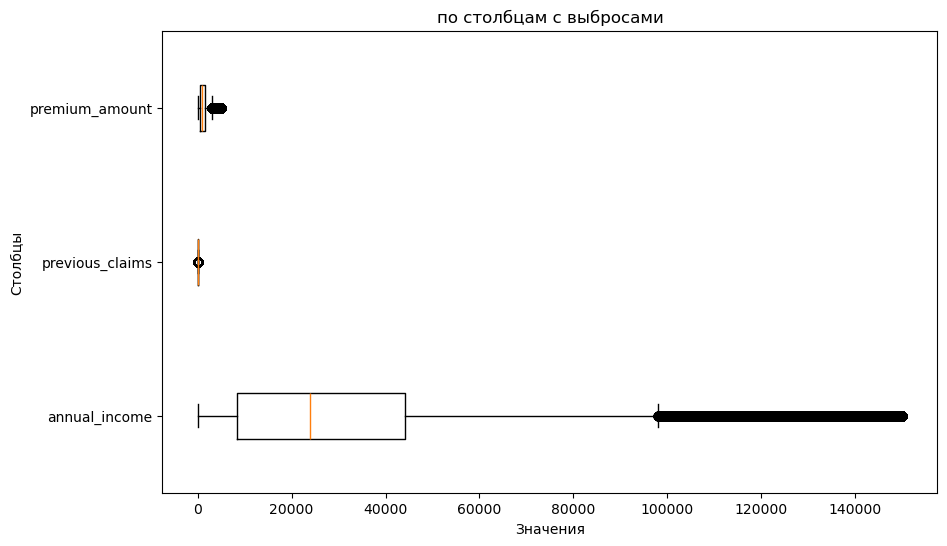

In [12]:
get_boxplot(df[['annual_income', 'previous_claims', 'premium_amount']], 'по столбцам с выбросами').show()

In [13]:
# Корректировка выбросов по верхней границе
def get_iqr_bounds(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Вычисляем границы для каждого столбца
l_lower, l_upper = get_iqr_bounds(df['annual_income'])
df['annual_income'] = df['annual_income'].clip(upper=l_upper)

l_lower, l_upper = get_iqr_bounds(df['premium_amount'])
df['premium_amount'] = df['premium_amount'].clip(upper=l_upper)

l_lower, l_upper = get_iqr_bounds(df['previous_claims'])
df['previous_claims'] = df['previous_claims'].clip(upper=l_upper)

In [14]:
# sns.pairplot(df)
# plt.title('Пары графиков для всех отношений')
# plt.show()
print('f-------')

f-------


Выбор критериев для обучения
- лудшие признаки
- тепловая матрица с ограничением по корреляции

In [ ]:
# Выбор лудших признаков
X = df.drop(columns=['premium_amount'])  # Все признаки
y = df['premium_amount']  # Целевая переменная

# Создаем объект SelectKBest и выбираем k лучших признаков
k = 4  # Задайте количество признаков, которые хотите выбрать
selector = SelectKBest(score_func=f_regression, k=k)

# Применяем селектор к данным
X_new = selector.fit_transform(X, y)

# Получаем индексы выбранных признаков
selected_indices = selector.get_support(indices=True)

# Получаем названия выбранных признаков
selected_features = X.columns[selected_indices]

# Выводим выбранные признаки
print("Выбранные признаки:")
print(selected_features)

Выбранные признаки:
Index(['annual_income', 'health_score', 'previous_claims', 'credit_score'], dtype='object')


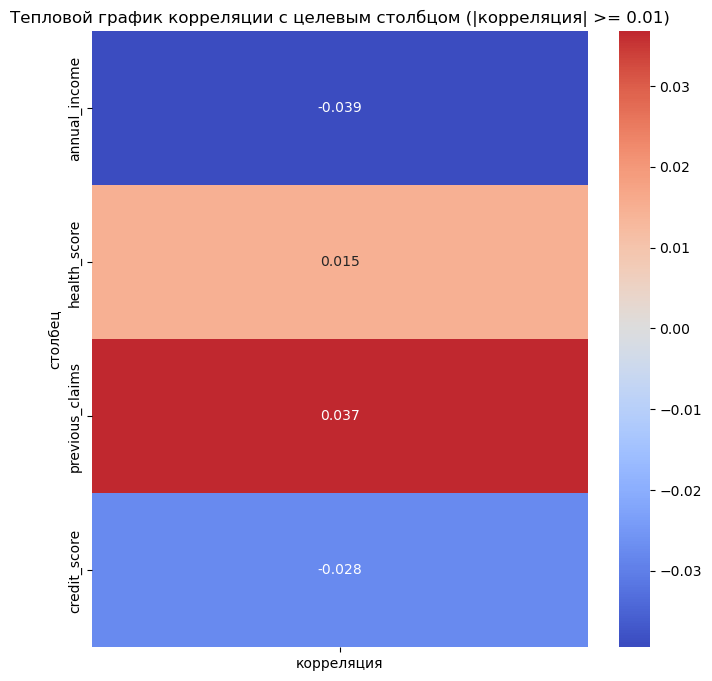

annual_income     -0.039484
health_score       0.014854
previous_claims    0.036770
credit_score      -0.027599
Name: premium_amount, dtype: float64

In [16]:
correlation = df.corr()['premium_amount'].drop('premium_amount')

# Фильтруем столбцы с модулем корреляции >= 0.01
filtered_correlation = correlation[abs(correlation) >= 0.01]

# Преобразуем в DataFrame
correlation_df = pd.DataFrame(filtered_correlation).reset_index()
correlation_df.columns = ['столбец', 'корреляция']

# Построим тепловой график
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_df.set_index('столбец'), annot=True, cmap='coolwarm', center=0)
plt.title('Тепловой график корреляции с целевым столбцом (|корреляция| >= 0.01)')
plt.show()
filtered_correlation

У всех признаков кореляция с target не значительная, R^2 будет стремиться к 0

In [17]:
# Выбранные поля для обучения:
df = df[['annual_income', 'health_score', 'previous_claims', 'credit_score','premium_amount']]

Трансформация данных

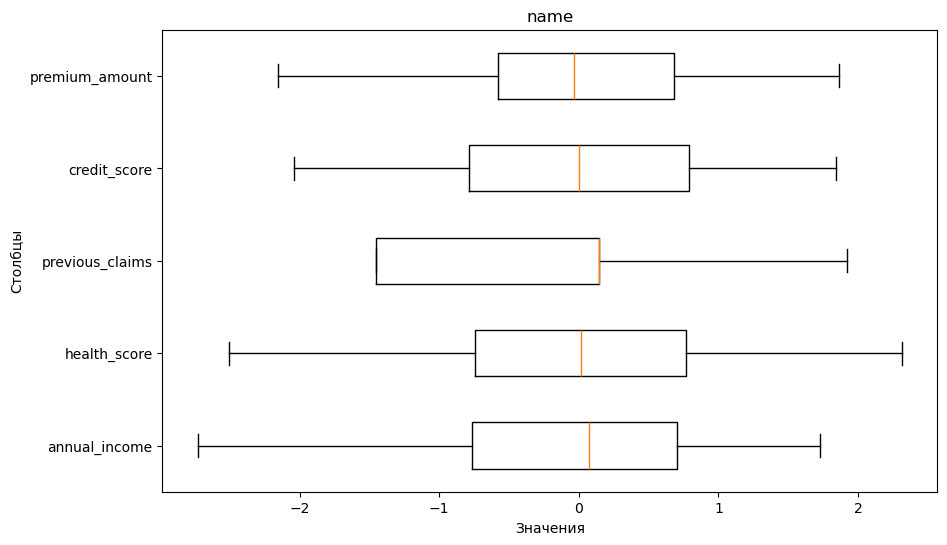

In [18]:
from sklearn.preprocessing import PowerTransformer
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True) 

# Применение трансформации к числовым признакам
# Выбираем только числовые столбцы для масштабирования
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = power_transformer.fit_transform(df[numeric_columns])

# # Масштабирование с помощью MinMaxScaler
# minmax_scaler = MinMaxScaler()
# scaled_data_minmax = minmax_scaler.fit_transform(df)
# df_minmax_scaled = pd.DataFrame(scaled_data_minmax, columns=df.columns)
# df = df_minmax_scaled
get_boxplot(df,'name').show()

In [19]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = df[['annual_income', 'health_score', 'previous_claims', 'credit_score' ]]    
# X = df.drop(columns=['premium_amount'])  # Все столбцы, кроме целевого
y = df['premium_amount']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Линейная регрессия
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_linear = linear_model.predict(X_test)

In [21]:
# Полиномиальная регрессия
degree = 8 # Настройка степени полинома
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_poly = poly_model.predict(X_test)

In [22]:
# Функция для оценки качества модели
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Метрики для модели {model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R^2: {r2:.4f}")
    print("-" * 30)

In [23]:
# Оценка линейной модели
evaluate_model(y_test, y_pred_linear, "Линейная регрессия")

Метрики для модели Линейная регрессия:
MAE: 0.7933
MSE: 0.9905
RMSE: 0.9952
MAPE: 1.2436
R^2: 0.0086
------------------------------


In [24]:
# Оценка полиномиальной модели
evaluate_model(y_test, y_pred_poly, f"Полиномиальная регрессия (степень {degree})")

Метрики для модели Полиномиальная регрессия (степень 8):
MAE: 0.7706
MSE: 0.9575
RMSE: 0.9785
MAPE: 1.2627
R^2: 0.0416
------------------------------


In [25]:
#  Кросс-валидация для полиномиальной модели
cv_scores = cross_val_score(poly_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f"Результаты кросс-валидациидля полиномиальной модели:")
print(f"Среднее RMSE: {cv_rmse_scores.mean():.4f}")
print(f"Стандартное отклонение RMSE: {cv_rmse_scores.std():.4f}")
print("Среднее R^2 score:", np.mean(cv_scores))

Результаты кросс-валидациидля полиномиальной модели:
Среднее RMSE: 0.9796
Стандартное отклонение RMSE: 0.0020
Среднее R^2 score: -0.9596178378185487


Выводы:
- обе модели показывают большие ошибки и не применимы на практике. 
- полиномиальная модель дает более качественные результаты.
- кросс-валидация для полиномиальной модели говорит о том что модель работает хуже чем предсказание по среднему значению.

Возможно дело в подготовке данных, слабой кореляции между признаками и целью, ненормальным распределением данных.
